In [1]:
import pickle
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
from hsa_model import HSAPotential, save_potential

# read in all the data
data_folder = '/home/joseph/workspaces/hsa_hopper/hop_data/hsa_identification'
experiment_configs = {}
hardware_configs = {}
data = {}
for rel_path in os.listdir(data_folder):
    path = os.path.join(data_folder, rel_path)
    if os.path.isdir(path):
        with open(os.path.join(path, 'experiment_config.yaml'), 'r') as f:
            experiment_configs[rel_path] = yaml.load(f, yaml.Loader)
        with open(os.path.join(path, 'hardware_config.yaml'), 'r') as f:
            hardware_configs[rel_path] = yaml.load(f, yaml.Loader)
        with open(os.path.join(path, 'data.pickle'), 'rb') as f:
            data[rel_path] = pickle.load(f)

ModuleNotFoundError: No module named 'hsa_model'

In [2]:
def calculate_dynamics(x, t):
    M = len(t)
    A = np.zeros((3*(M-2), 2*(M-1)))
    b = np.zeros((3*(M-2)))
    for i in range(0,M-2):
        dt = t[i]-t[i-1]
        A[3*i, 2*i] = dt
        A[3*i, 2*i+1] = .5*dt**2
        b[3*i] = x[i]-x[i+1]

        dt = t[i+1]-t[i]
        A[3*i+1, 2*i] = 1
        A[3*i+1, 2*i+1] = dt
        A[3*i+1, 2*i+2] = -1
        b[3*i+1] = 0.

        A[3*i+2, 2*i] = -dt
        A[3*i+2, 2*i+1] = .5*dt**2
        b[3*i+1] = x[i+1]-x[i+2]
    
    coeffs, error, rank, sigma = np.linalg.lstsq(A,b)
    xdot = coeffs[0:-2:2]
    xddot = coeffs[1:-1:2]
    return xdot, xddot


In [3]:
key = list(data.keys())[0]
experiment = data[key]
N_trials = len(experiment['times'])
x = []
t = []
xdot = []
xddot = []
torque = []
l = []
dldx = []
psi = []
skip = 40
for i in range(N_trials):
    _x = experiment['motor_angle'][i][0:-1:skip]
    _t = experiment['times'][i][0:-1:skip]
    _tau = experiment['motor_torque'][i][0:-1:skip]
    _l = experiment['hsa_len'][i][0:-1:skip]
    _dl_dx = experiment['dldtheta'][i][0:-1:skip]
    _xdot, _xddot = calculate_dynamics(_x,_t)
    x.append(_x[1:-1])
    t.append(_t[1:-1])
    torque.append(_tau[1:-1])
    l.append(_l[1:-1])
    dldx.append(_dl_dx[1:-1])
    psi.append(experiment['hsa_angle'][i]*(np.pi/180)*np.ones(len(_x)))
    xdot.append(_xdot)
    xddot.append(_xddot)


/tmp/ipykernel_19762/3654898955.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, error, rank, sigma = np.linalg.lstsq(A,b)


In [4]:
# pick 5 lengths uniformly from each trial
# l_min = min(min(foo for foo in l[i]) for i in range(len(l)))
# l_max = max(max(foo for foo in l[i]) for i in range(len(l)))
y = np.vstack(tuple([[_l, psi[i][0]] for _l in np.linspace(min(l[i]), max(l[i]), len(psi))] for i in range(len(psi))))
# y = np.vstack(tuple([[_l, psi[i][0]] for _l in np.linspace(l_min, l_max, len(psi))] for i in range(len(psi))))

class HSAPotential:
    def __init__(self, 
                 v: np.array, # kernel weights i.e. estimates of potential at configuration
                 y: np.array, # sample configurations corresponding to weights in v
                 s: float):   # length-scale parameter used by kernels
        self.N = y.shape[0]
        self.v = v
        self.y = y
        self.s = s
        self.S = S = np.cov(y.T)
        self.Sinv = Sinv = np.linalg.inv(S)

        # distance function, and its gradient, and hessian
        self.rho = lambda z, i: np.dot(z-y[i,:], Sinv@(z-y[i,:]))/s**2
        self.drho = lambda z, i: 2*Sinv@(z-y[i,:])/s**2
        self.d2rho = lambda z, i: 2*Sinv/s**2

        # square exponential kernel, its gradient, and hessian
        self.k = lambda z, i: np.exp(-self.rho(z,i))
        self.dk = lambda z, i: (self.k(z,i))*(-self.drho(z,i))
        self.d2k = lambda z, i: self.k(z,i)*(self.drho(z,i)@self.drho(z,i).T - self.d2rho(z,i))

    def V(self, z: np.array):
        return sum(self.v[i]*self.k(z,i) for i in range(self.N))
    
    def dV(self, z: np.array):
        return sum(self.v[i]*self.dk(z,i) for i in range(self.N))

    def d2V(self, z: np.array):
        return sum(self.v[i]*self.d2k(z,i) for i in range(self.N))

In [5]:
N = y.shape[0]
M = sum(len(t[i]) for i in range(len(t)))
# s = 1/np.sqrt(2) # length scale for the Gaussian process regressor
s = np.sqrt(2)
v = np.zeros(y.shape[0])
potential = HSAPotential(v, y, s)

# stack all the data for access by a common index
_x = np.hstack(x)
_t = np.hstack(t)
_xdot = np.hstack(xdot)
_xddot = np.hstack(xddot)
_l = np.hstack(l)
_dldx = np.hstack(dldx)
_tau = np.hstack(torque)
_psi = np.hstack(psi)
# thats a pretty damn big system of equations
# lets assemble the A-matrix and b-vector
A = np.zeros((M,2+N))
b = np.zeros((M))
for i in range(M):
    b[i] = _tau[i]
    A[i,0] = -_xddot[i]
    A[i,1] = -_xdot[i]
    for j in range(N):
        z = np.array([_l[i], _psi[i]])
        A[i,2+j] = _dldx[i]*(potential.dk(z, j)[0])
coeffs, error, rank, sigma = np.linalg.lstsq(A,b,rcond=None)
potential.v[:] = coeffs[2:]
print(np.sqrt(error/M))
print(rank)
coeffs[1]

[0.15266049]
51


0.21362742799773302

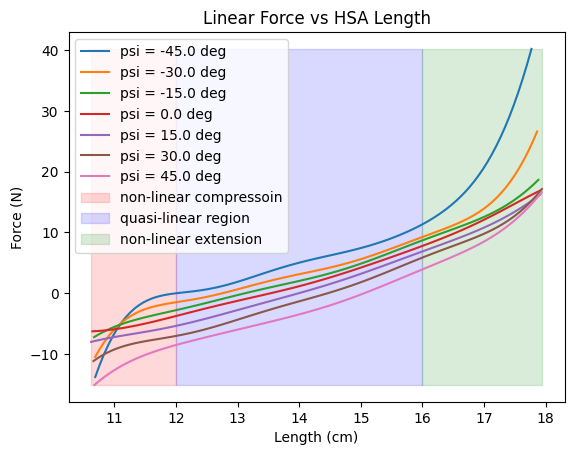

In [6]:
# plot this potential function for a range of theta values, fix psi = 0.

# for i in range(len(psi)):
fig, ax = plt.subplots()
for i in range(len(psi)):
    _psi = psi[i][0]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(z[:,0]*100, [potential.dV(z[i,:])[0] for i in range(len(hsa_lens))], label=f'psi = {(_psi*180/np.pi):.1f} deg')
ax.set_title('Linear Force vs HSA Length')
ax.set_xlabel('Length (cm)')
ax.set_ylabel('Force (N)')

xmin = min(min(line.get_xdata()) for line in ax.lines)
xmax = max(max(line.get_xdata()) for line in ax.lines)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compressoin')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.legend()

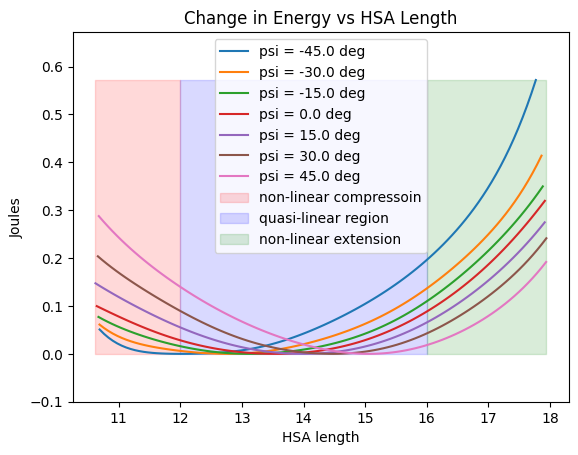

In [7]:
fig, ax = plt.subplots()
for i in range(len(psi)):
    _psi = psi[i][0]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(100*z[:,0], [potential.V(z[i,:]) for i in range(len(hsa_lens))], label=f'psi = {(_psi*180/np.pi):.1f} deg')
ax.set_title('Change in Energy vs HSA Length')
ax.set_xlabel('HSA length')
ax.set_ylabel('Joules')
for i, line in enumerate(ax.lines):
    ydata = np.array(line.get_ydata())
    ydata -= np.min(ydata)
    line.set_ydata(ydata)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compressoin')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.set_ylim([ymin-.1, ymax+.1])
# ax.legend(loc=[.35,.45])
ax.legend()

In [8]:
from scipy.optimize import root_scalar
# code to find rest length of HSA as a function of twist

def R(psi, bracket):
    f = lambda l, psi: potential.dV(np.array([l, psi]))[0]
    sol = root_scalar(f, (psi,), method='bisect', bracket=bracket, xtol = 1e-9)
    return sol.root

In [9]:
from scipy.optimize import minimize, LinearConstraint
omega = (5*np.pi)
mass = np.array([1.2, 1.8, 2.2])
E = np.array([m*9.81*.04 for m in mass])
K_sys = np.array([m*omega**2 for m in mass])
K_ground = np.array([10000, 5000, 2000, 1000])
K_leg = np.array([[1/(1/K1-1/K2) for K2 in K_ground] for K1 in K_sys])
dx = np.array([
    [np.sqrt(2*E[i]/K_leg[i,j]/(1+K_leg[i,j]/K_ground[j])) for j in range(len(K_ground))] 
    for i in range(len(E))
])
E_leg = np.array([
    [.5*K_leg[i,j]*dx[i,j]**2 for j in range(dx.shape[1])]
    for i in range(dx.shape[0])
])

# lots and lots of analysis
def F(z, dx, E_leg):
    # get rest length
    l0 = z[0]
    l1 = l0 + dx
    z0 = np.array([l0, z[1]])
    z1 = np.array([l1, z[1]])
    E = potential.V(z1)-potential.V(z0)
    f = (E - E_leg)**2

    # calculate gradient wrt psi
    dE = potential.dV(z1)-potential.dV(z0)
    return f, 2*(E-E_leg)*dE

result = np.zeros((2,*dx.shape))
for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
        z0 = [R(10*np.pi/180, [.11,.18]),10*np.pi/180]
        constraints = [
            LinearConstraint(np.array([1,0]),lb=.1,ub=.185-dx[i,j]),
            LinearConstraint(np.array([0,1]),lb=-np.pi/4,ub=np.pi/4)
        ]
        sol = minimize(F,z0,args=(dx[i,j],E_leg[i,j]),method='SLSQP',jac=True,constraints=constraints)
        result[:,i,j] = sol.x


In [11]:
# print(sol.x*180/np.pi)
# print(R(sol.x, [.1,.18])+dx[1,2])
print(result[0,:,:]+dx)
print(result[1,:,:]*180/np.pi)

[[0.18481728 0.18445412 0.18497028 0.1816538 ]
 [0.18306768 0.18487085 0.185      0.18419695]
 [0.18499154 0.18196406 0.18456311 0.18496436]]
[[ -9.83152213  -8.14720369   7.19553757   9.47058578]
 [-37.02995882 -30.58000843 -24.56306624 -10.14878486]
 [-38.6192415  -45.         -32.35949824 -17.31368328]]
